<a href="https://colab.research.google.com/github/rahul-727/Predictive-Analytics/blob/main/2348544_Lab7_PL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [3]:
data = pd.read_csv('/content/AEP_hourly.csv')
data.head()

,Datetime,AEP_MW
0,2004-12-31 01:00:00,13478.0
1,2004-12-31 02:00:00,12865.0
2,2004-12-31 03:00:00,12577.0
3,2004-12-31 04:00:00,12517.0
4,2004-12-31 05:00:00,12670.0


In [4]:
data.columns

Index(['Datetime', 'AEP_MW'], dtype='object')

In [5]:
data['Datetime'] = pd.to_datetime(data['Datetime'])
data.set_index('Datetime', inplace=True)

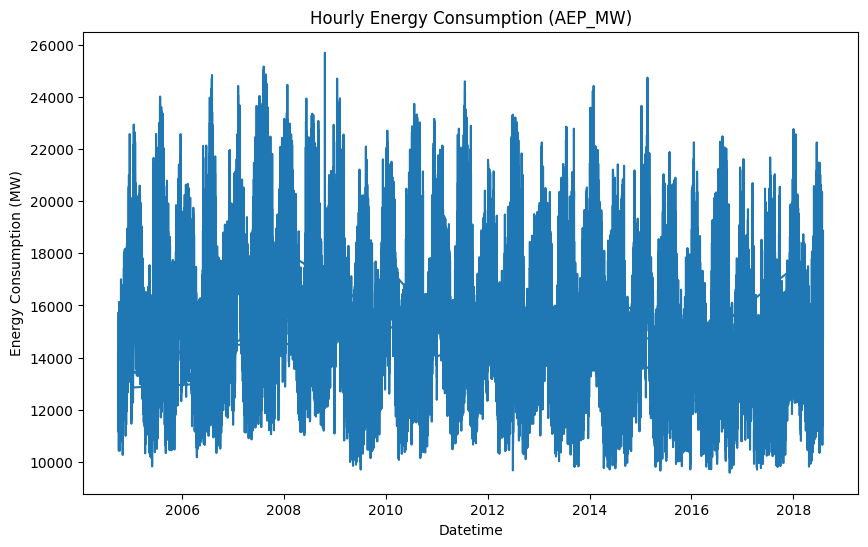

In [6]:
# Visualize the data
plt.figure(figsize=(10, 6))
plt.plot(data['AEP_MW'])
plt.title('Hourly Energy Consumption (AEP_MW)')
plt.xlabel('Datetime')
plt.ylabel('Energy Consumption (MW)')
plt.show()

In [7]:
# Differencing the data if required (e.g., if there's a clear trend)
data_diff = data['AEP_MW'].diff().dropna()

ACF (Autocorrelation Function): Measures the correlation between a time series and its lagged values.
PACF (Partial Autocorrelation Function): Measures the correlation between a time series and its lagged values, controlling for the correlations at shorter lags.

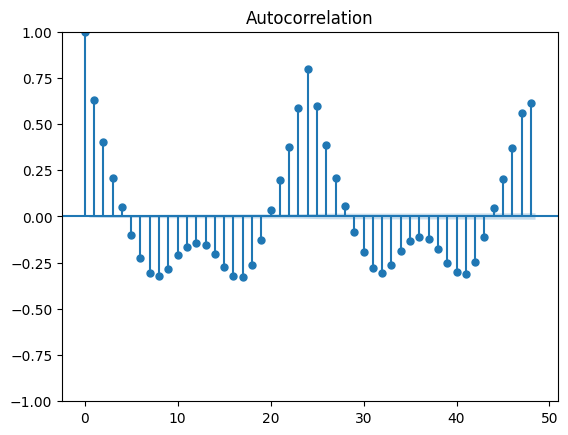

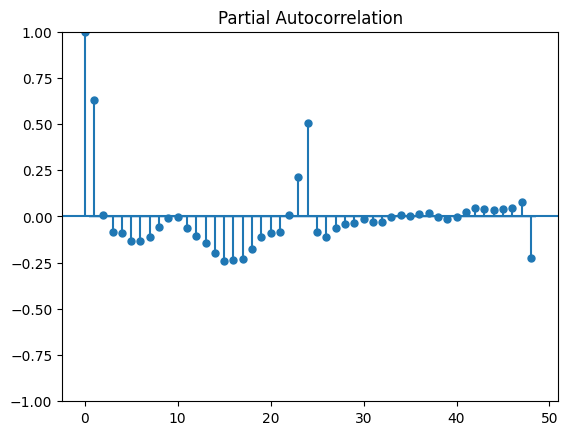

In [8]:
# Plot ACF and PACF to determine initial SARIMA parameters
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(data_diff, lags=48)  # Use lags as per your dataset periodicity
plot_pacf(data_diff, lags=48)
plt.show()

Seasonal Order (P, D, Q)
Since there’s clear seasonality, the seasonal differencing order D can be set to 1.
The autocorrelation pattern indicates that P (seasonal autoregressive term) and Q (seasonal moving average term) can start with values of 1.

The ACF plot shows recurring peaks every 24 lags, which indicates strong daily seasonality (since the data is hourly, 24 lags correspond to one day).
Set m=24 to capture this daily seasonality.

In [9]:
p, d, q = 1, 1, 1
P, D, Q, m = 1, 1, 1, 24

# Split data into train and test sets
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

In [10]:
# Fit the SARIMA model
model = SARIMAX(train['AEP_MW'],
                order=(p, d, q),
                enforce_stationarity=False,
                enforce_invertibility=False)

sarima_fit = model.fit(disp=False)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


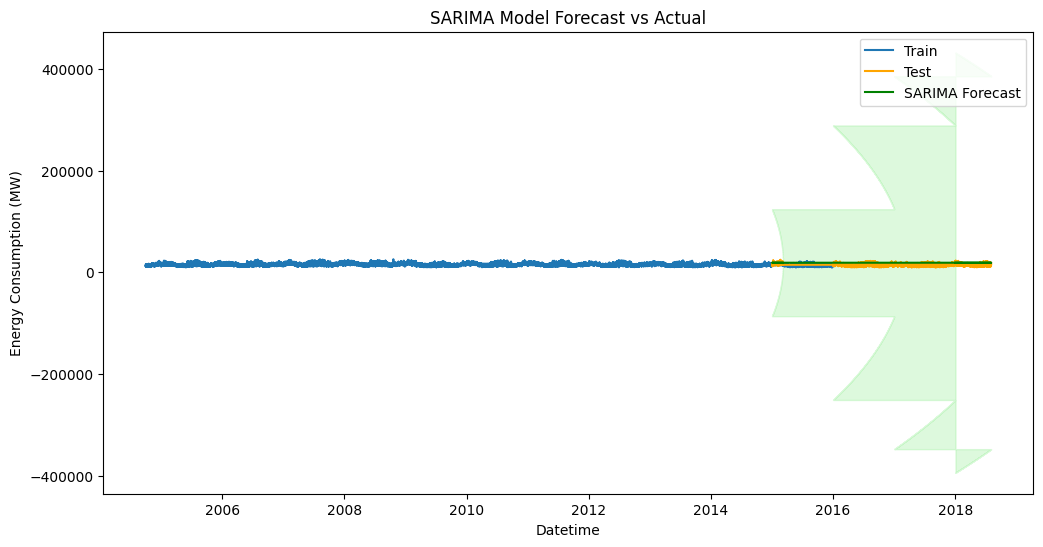

In [12]:
# Forecast
forecast_steps = len(test)
forecast = sarima_fit.get_forecast(steps=forecast_steps)
forecast_ci = forecast.conf_int()

# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['AEP_MW'], label='Train')
plt.plot(test.index, test['AEP_MW'], label='Test', color='orange')
plt.plot(test.index, forecast.predicted_mean, label='SARIMA Forecast', color='green')
plt.fill_between(test.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='lightgreen', alpha=0.3)
plt.xlabel('Datetime')
plt.ylabel('Energy Consumption (MW)')
plt.title('SARIMA Model Forecast vs Actual')
plt.legend()
plt.show()


 The SARIMA model generally captures the overall trend of the time series data well. The green forecast line follows the general ups and downs of the orange actual test data line. This means the model is able to identify and project the main patterns in energy consumption.

In [13]:
# Evaluation Metrics
y_true = test['AEP_MW']
y_pred = forecast.predicted_mean

mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = mse ** 0.5

print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')

MAE: 4083.265454701424
MSE: 21556200.98103456
RMSE: 4642.8656001476675


MAE (Mean Absolute Error): Measures the average magnitude of errors in the predictions, without considering their direction. An MAE of around 4083 MW means that, on average, the model’s predictions are off by about 4083 MW from the actual values.

MSE (Mean Squared Error): Squared error is more sensitive to large errors due to squaring, hence highlighting larger deviations. An MSE of over 21 million indicates that some errors are significantly larger, which could mean the model has some large outliers in its predictions.

RMSE (Root Mean Squared Error): Similar to MSE but in the same unit as the target variable (MW), which is helpful for interpretation. An RMSE of 4642.87 MW indicates that typical prediction errors are roughly this amount.

